# Import libraries

In [ ]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pooch
import tqdm
import xarray as xr
from c3s_eqc_automatic_quality_control import diagnostics, download
from matplotlib.colors import ListedColormap
from scipy import stats

# Set parameters

In [ ]:
# Shape of wind data-files
col_dict = {
    "SOUID": (0, 6),
    "SOUNAME": (7, 47),
    "CN": (48, 50),
    "LAT": (51, 60),
    "LON": (61, 71),
    "HGHT": (72, 76),
    "ELEID": (77, 81),
    "START": (82, 90),
    "STOP": (91, 99),
    "PARID": (100, 105),
    "PARNAME": (106, 156),
}

# Threshold for maximum allowed NaNs
max_nans = 365 * 5

# Define data request

In [ ]:
# Time
start = "1985-01-01"
stop = "2020-12-31"

# CERRA
cerra_id = "reanalysis-cerra-single-levels"
cerra_request = {
    "product_type": "analysis",
    "data_type": "reanalysis",
    "level_type": "surface_or_atmosphere",
    "variable": ["10m_wind_speed"],
    "time": ["00:00", "06:00", "12:00", "18:00"],
    "data_format": "grib",
}

# ERA5
era5_id = "reanalysis-era5-single-levels-timeseries"
era5_request = {
    "variable": ["10m_u_component_of_wind", "10m_v_component_of_wind"],
    "date": [f"{start}/{stop}"],
    "data_format": "netcdf",
}

# ECA European Climate Assessment & Dataset
eca_url = "https://knmi-ecad-assets-prd.s3.amazonaws.com/download/ECA_nonblend_fg.zip"

# Define functions to cache

In [ ]:
def dms_to_decimal(dms_str):
    """
    Convert a DMS (degrees:minutes:seconds) string to decimal degrees.

    Example input: '+54:19:32' -> 54.32555556
    """
    sign = -1 if dms_str.startswith("-") else 1
    dms_str = dms_str.strip("+-")  # Remove sign for splitting
    degrees, minutes, seconds = map(float, dms_str.split(":"))
    return sign * (degrees + minutes / 60 + seconds / 3600)


def extract_daily_stations(ds, grid_out, **xesmf_kwargs):
    (da,) = ds.data_vars.values()
    da = diagnostics.regrid(da, grid_out, **xesmf_kwargs)
    da = da.resample(forecast_reference_time="1D").mean()
    da = da.chunk(forecast_reference_time=-1, station=1)
    da.encoding["chunksizes"] = tuple(map(max, da.chunks))
    return da.to_dataset()


def compute_wind_speed(ds):
    da = np.hypot(ds["u10"], ds["v10"]).resample(time="1D").mean()
    da.attrs = {"long_name": "10 metre wind speed", "units": ds["u10"].units}
    return da.to_dataset(name="wind_speed")


def model_fit(da_reference, da_target, alpha=0.05):
    # stats.linregress gives you the slope, intercept, and the standard error of the slope in one call.
    # The critical-t multiplier converts standard errors into two-sided 95% intervals
    # (df = n–2 for simple linear regression).
    # The intercept standard error depends on the spread of the x values,
    # so we compute it explicitly from the residual variance

    # Fit the model  y = m·x + b
    slope, intercept, r_value, p_value, slope_std_err = stats.linregress(
        da_reference, da_target
    )

    # 1-alpha % confidence limits
    alpha = 0.05
    n = da_reference.size
    df = n - 2  # degrees of freedom
    t_crit = stats.t.ppf(1 - alpha / 2, df)  # two-sided critical t value

    slope_ci = (slope - t_crit * slope_std_err, slope + t_crit * slope_std_err)

    y_hat = slope * da_reference + intercept
    resid = da_target - y_hat
    sse = np.sum(resid**2)
    sigma2 = sse / df
    x_bar = da_reference.mean()
    Sxx = np.sum((da_reference - x_bar) ** 2)

    intercept_std_err = np.sqrt(sigma2 * (1 / n + x_bar**2 / Sxx))
    intercept_ci = (
        intercept - t_crit * intercept_std_err,
        intercept + t_crit * intercept_std_err,
    )

    return slope, slope_ci, intercept, intercept_ci


def compare_statistic_scatter(
    da, reference, targets, stat="mean", top_n_outliers=4, ax=None, season=None
):
    season_months = {
        "DJF": [12, 1, 2],
        "MAM": [3, 4, 5],
        "JJA": [6, 7, 8],
        "JAS": [7, 8, 9],
        "SON": [9, 10, 11],
        "OND": [10, 11, 12],
    }
    # Apply month and positivity filter
    da = da.where(da > 0)
    if season is not None:
        da = da.where(da["time"].dt.month.isin(season_months[season]))
    da = getattr(da, stat)("time")
    da_reference = da.sel(product=reference)
    for target, colour in targets.items():
        da_target = da.sel(product=target)

        # Perform linear regression: fit y = m*x + b
        slope, slope_ci, intercept, intercept_ci = model_fit(
            da_reference, da_target, alpha=0.05
        )
        # slope, intercept = np.polyfit(da_reference, da_target, 1)
        fit_line = slope * da_reference + intercept

        # Compute R^2
        res = np.sum((da_target - fit_line) ** 2)
        tot = np.sum((da_target - np.mean(da_target)) ** 2)
        r_squared = 1 - res / tot

        # Compute residuals and find 4 largest outliers
        residuals = np.abs(da_target - fit_line)
        outlier_indices = np.argsort(residuals)[-top_n_outliers:]  # n largest residuals

        # Create plot
        if ax is None:
            ax = plt.gca()
        # Create scatter plot
        ax.scatter(da_reference, da_target, color=colour, alpha=0.7)
        min_val = min(da_target.min().item(), da_reference.min().item())
        max_val = max(da_target.max().item(), da_reference.max().item())
        ax.plot([min_val, max_val], [min_val, max_val], "k-", label="_")
        ax.plot(
            da_reference,
            fit_line,
            f"{colour}-",
            label=(
                f"{target} "
                f"m = {[f'{s:.2f}' for s in slope_ci]} "
                f"b = {[f'{b:.2f}' for b in intercept_ci]} "
                f"(R² = {r_squared:.2f})"
            ),
        )

        # Annotate outliers
        for i in outlier_indices:
            ax.annotate(
                str(da["SOUNAME"][i].values),
                (da_reference[i], da_target[i]),
                textcoords="offset points",
                xytext=(5, 5),
                ha="left",
                fontsize=9,
                color="darkred",
            )

    # Plot labels and title
    ax.set_xlim(min_val, max_val)
    ax.set_ylim(min_val, max_val)
    ax.set_xlabel(f"{reference} [m/s]")
    ax.set_ylabel("Reanalysis [m/s]")
    ax.set_title(f"{season}")
    ax.grid(True)
    ax.legend(fontsize=10)

stats.linregress gives you the slope, intercept, and the standard error of the slope in one call.

The critical-t multiplier converts those standard errors into two-sided 95 % intervals (df = n–2 for simple linear regression).

The intercept standard error depends on the spread of the x values, so we compute it explicitly from the residual variance

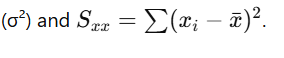
.

# Import and filter weather station data

## Import data

In [ ]:
fnames = pooch.retrieve(url=eca_url, known_hash=None, processor=pooch.Unzip())

## Extract metadata

In [ ]:
# Extract metadata in df_sources
(fname,) = [fname for fname in fnames if "sources" in fname]
df_sources = pd.read_fwf(
    fname,
    colspecs=list(col_dict.values()),
    skiprows=24,
    names=list(col_dict),
)

# Convert LAT and LON to decimal degrees
for col in ["LAT", "LON"]:
    df_sources[col] = df_sources[col].apply(dms_to_decimal)

# Convert START and STOP to datetime
for col in ["START", "STOP"]:
    df_sources[col] = pd.to_datetime(df_sources[col], format="%Y%m%d")

## Filter best quality (FG1, FG2) and check data availability by country

In [ ]:
# 1. Filter for FG1 and FG2
df_plot = df_sources[df_sources["ELEID"].isin(["FG1", "FG2"])]

# 2. Group by CN and SOURCE to count entries
# Turns ELEID into columns: FG1, FG2
df_plot = df_plot.groupby(["CN", "ELEID"]).size().unstack(fill_value=0)

# 3. Add total count and sort by it
df_plot["Total"] = df_plot.sum(axis=1)
df_plot = df_plot.sort_values(by="Total", ascending=False).drop(columns="Total")

# 4. Plotting
df_plot.plot(
    kind="bar",
    stacked=False,
    color={"FG1": "cornflowerblue", "FG2": "lightcoral"},
    figsize=(12, 6),
)

# 5. Customize the plot
plt.title("Number of FG1 and FG2 ELEID per Country", fontsize=16)
plt.xlabel("Country", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=90)
plt.legend(title="ELEID")
plt.tight_layout()

del df_plot

## Import daily weather station data for target country

In [ ]:
# Import data for Norway, with the largest number of FG2 quality data
country_code = "NO"
country_stations_meta = df_sources[df_sources["CN"] == country_code]

# Ensure the source id's SOUID values are strings (in case some are not)
country_stations_id = country_stations_meta["SOUID"].astype(str).tolist()

# Filter filenames that contain any of the SOUID string in the selected stations
country_fnames = [
    fname
    for fname in fnames
    if any(f"SOUID{id_}" in fname for id_ in country_stations_id)
]

# Read the data. Each array has attrbutes from the corresponding row of the dataframe country_stations
# (this may be improved with more efficient coding)
dataarrays = []
for fname in tqdm.tqdm(country_fnames):
    # Read CSV into a DataFrame
    df = pd.read_csv(fname, skipinitialspace=True, skiprows=18)

    # Convert DATE to datetime format
    df["DATE"] = pd.to_datetime(df["DATE"], format="%Y%m%d")

    # Filter out missing values
    df = df[df["FG"] != -9999]

    # Optionally use SOUID or STAID as the label if available
    souid = df["SOUID"].iloc[0]

    # Extract metadata for the current stattion
    meta = country_stations_meta[country_stations_meta["SOUID"] == souid].iloc[0]

    # Convert to DataArray
    da = xr.DataArray(
        data=df["FG"].values,
        coords={"time": df["DATE"].values},
        dims=["time"],
        name="FG",
    )
    da = da.expand_dims(station=[str(souid)])
    da = da.assign_coords({k: ("station", [v]) for k, v in meta.items()})
    dataarrays.append(da)

obs = xr.concat(dataarrays, "station").sel(time=slice(start, stop))
obs["LON"].attrs["standard_name"] = "longitude"
obs["LAT"].attrs["standard_name"] = "latitude"
grid_out = obs.to_dataset().drop_dims("time")[["LAT", "LON"]]
del dataarrays, df_sources

## Filter weather stations with sufficient amount of available records

In [ ]:
obs = obs.where(obs.isnull().sum("time") < max_nans, drop=True)

## Plot available data

In [ ]:
# Plot
cmap = ListedColormap(
    [
        (1, 0, 0, 0),  # Transparent for NaN    (0)
        (1, 0, 0, 1),  # Red for available data (1)
    ]
)
plt.figure(figsize=(15, obs.sizes["station"] * 0.3))
plt.imshow(
    obs.notnull().squeeze(),
    aspect="auto",
    interpolation="none",
    extent=[*obs["time"].values[[0, -1]], 0, obs.sizes["station"]],
    cmap=cmap,
)

# Ticks and labels
plt.yticks(np.arange(obs.sizes["station"]) + 0.5, obs["SOUNAME"].values)
plt.xlabel("Time")
plt.ylabel("Station")
plt.title("Data Availability Over Time by Station")
plt.colorbar(label="Data Present (1=Yes, 0=No)", ticks=[0, 1])
plt.tight_layout()
plt.show()

# Map weather stations

In [ ]:
# Extract station metadata
lats = obs["LAT"].values  # latitude  (shape: n_stations,)
lons = obs["LON"].values  # longitude
names = obs["SOUNAME"].values  # station names

# Define the Lambert-Conformal projection
proj = ccrs.LambertConformal(
    central_longitude=15,  # roughly the middle of Norway
    central_latitude=67,  # latitude of balance
    standard_parallels=(60, 80),  # secant cone cuts; tweak if needed
)

# Build the map
fig = plt.figure(figsize=(8, 10))
ax = plt.axes(projection=proj)

# Focus on mainland and northern Norway
ax.set_extent([-5, 33, 57, 80], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.LAND, facecolor="#f0f0f0")
ax.add_feature(cfeature.COASTLINE, linewidth=0.6)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.gridlines(draw_labels=True, linewidth=0.25, linestyle="--")

# Plot the station locations
ax.scatter(
    lons,
    lats,
    s=25,
    color="darkred",
    edgecolors="k",
    zorder=3,
    transform=ccrs.PlateCarree(),
)

# Annotate each station
# for lon, lat, name in zip(lons, lats, names):
#    ax.text(
#        lon + 0.25, lat + 0.15, name,
#        fontsize=6, transform=ccrs.PlateCarree(), zorder=4
#    )

ax.set_title("Weather Stations with quality wind data in Norway", pad=12)
plt.tight_layout()
plt.show()

# Import CERRA

In [ ]:
# Import CERRA at the nearest grid points to se
request = download.update_request_date(cerra_request, start, stop, stringify_dates=True)
ds = download.download_and_transform(
    cerra_id,
    request,
    transform_func=extract_daily_stations,
    transform_func_kwargs={
        "grid_out": grid_out,
        "method": "nearest_s2d",
        "locstream_out": True,
    },
    chunks={"year": 1, "month": 1},
    drop_variables=["step"],
    cached_open_mfdataset_kwargs={
        "concat_dim": "forecast_reference_time",
        "combine": "nested",
        "data_vars": "minimal",
        "coords": "minimal",
        "compat": "override",
    },
)
(cerra,) = ds.sel(station=obs["station"]).data_vars.values()

# Import ERA5

In [ ]:
datasets = []
for station, da_station in tqdm.tqdm(obs["station"].groupby("station")):
    ds = download.download_and_transform(
        era5_id,
        era5_request
        | {
            "location": {
                "longitude": da_station["LON"].item(),
                "latitude": da_station["LAT"].item(),
            }
        },
        transform_func=compute_wind_speed,
        quiet=True,
    )
    datasets.append(ds.expand_dims(station=[station]))
(era5,) = xr.concat(datasets, "station").data_vars.values()

### Combine dataarrays

In [ ]:
da = xr.concat(
    [
        cerra.expand_dims(product=["CERRA"]).rename(forecast_reference_time="time"),
        obs.expand_dims(product=["OBS"]).rename(cerra.name) / 10,
        era5.expand_dims(product=["ERA5"]),
    ],
    "product",
)
da["time"].attrs = {"long_name": "time"}
da = da.compute()
del cerra, era5, obs

In [ ]:
# List of statistics to compare
statistics = ["mean", "var", "min", "max"]
seasons = ["DJF", "MAM", "JJA", "SON"]
targets = {"CERRA": "r", "ERA5": "g"}

for j, stat in enumerate(statistics):
    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    axes = axes.flatten()

    # Plot each statistic in a subplot
    for i, season in enumerate(seasons):
        compare_statistic_scatter(
            da,
            "OBS",
            targets,
            stat=stat,
            top_n_outliers=2,
            ax=axes[i],
            season=season,
        )

    plt.suptitle(
        f"Reanalysis vs. observations  {stat.capitalize()} Wind Speed Statistics",
        fontsize=16,
    )
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()